In [2]:
#Load EEG data - preprocessed
import mne
import numpy as np
%matplotlib qt

#Subject numbers and experiment
sub = "sub-28"
exp = "fixthemix"

fname = f"../data/{sub}_task-{exp}_eegprep.vhdr"

raw = mne.io.read_raw_brainvision(fname, preload=True)
events, event_dict = mne.events_from_annotations(raw)
#start of songs in sample numbers
song_starts = np.array(events)[events[:,2] == 10001][2:,0]
press_starts = []
press_starts = events[2:,0]

print(event_dict)
#set sample rate
sample_rate = 250
#raw.plot()


Extracting parameters from ../data/sub-28_task-fixthemix_eegprep.vhdr...
Setting channel info structure...
Reading 0 ... 465922  =      0.000 ...  1863.688 secs...
Used Annotations descriptions: ['New Segment/', 'Stimulus/1', 'Stimulus/11', 'Stimulus/12', 'Stimulus/13', 'Stimulus/15', 'Stimulus/2', 'Stimulus/21', 'Stimulus/22', 'Stimulus/23', 'Stimulus/25', 'Stimulus/3', 'Stimulus/31', 'Stimulus/32', 'Stimulus/33', 'Stimulus/35', 'Stimulus/41', 'Stimulus/42', 'Stimulus/43', 'Stimulus/45', 'Time 0/']
{'New Segment/': 99999, 'Stimulus/1': 10001, 'Stimulus/11': 10002, 'Stimulus/12': 10003, 'Stimulus/13': 10004, 'Stimulus/15': 10005, 'Stimulus/2': 10006, 'Stimulus/21': 10007, 'Stimulus/22': 10008, 'Stimulus/23': 10009, 'Stimulus/25': 10010, 'Stimulus/3': 10011, 'Stimulus/31': 10012, 'Stimulus/32': 10013, 'Stimulus/33': 10014, 'Stimulus/35': 10015, 'Stimulus/41': 10016, 'Stimulus/42': 10017, 'Stimulus/43': 10018, 'Stimulus/45': 10019, 'Time 0/': 10020}


In [5]:
#Load FLAC Audio in
import pyflac
import scipy.io.wavfile as wav
import scipy.signal as sig
from sklearn.preprocessing import StandardScaler

aname = f"../data/{sub}_task-{exp}_aud.flac"
decoder = pyflac.FileDecoder(aname, "temp.wav")
samp_rate, audio = wav.read("../temp.wav")
print(audio.shape)
print(raw.get_data().shape)

#Resample audio to EEG sample rate and get audio envelope
audio = sig.resample(audio, raw.get_data().shape[1])
audio = np.abs(sig.hilbert(audio.T))
audio = np.average(audio, axis=0)
print(audio)
print(np.max(audio), np.min(audio))

#normalize audio
# scaler = StandardScaler()
# audio = scaler.fit_transform(audio.reshape(-1,1)).reshape(1, -1)
# print(audio)
# print(np.max(audio), np.min(audio))
# print(np.mean(audio), np.std(audio))


(82188285, 2)
(31, 465923)
[3.89786261 2.16101743 3.89697985 ... 2.16272319 3.89874611 2.16186872]
37195.47015751086 2.014702518637015


In [6]:
#HELPER FUNCTIONS
#================

def split_events(X, Y, events, sample_rate, bound):

    new_X = []
    new_Y = []

    for event in events:
        new_X.append(X[:,event - (sample_rate*bound):event + (sample_rate*bound)])
        new_Y.append(Y[:,event - (sample_rate*bound):event + (sample_rate*bound)])

    return new_X, new_Y



#Build regression matrix
#Adapted from https://stackoverflow.com/questions/5842903/block-tridiagonal-matrix-python 
from scipy.sparse import diags
import numpy as np
fs = 250

#lag_mat takes a given input (stimulus) and generates a time-lagged matrix
#currently set up only for the forward model
def lag_mat(stimulus, sample_rate):

    #sampling frequency
    fs = sample_rate
    #start and end in seconds * frequency = num of samples
    start = int(np.floor(-0.25*fs))
    end = int(np.ceil(0.85*fs))

    #time lag list - sample points for the time lags
    lags = list(range(int(np.floor(-0.25 * fs)), int(np.ceil(0.85 * fs)) + 1))
    n_lags = len(lags)

    #Adapted from https://github.com/powerfulbean/mTRFpy/blob/master/mtrf/matrices.py
    x = np.array([stimulus]).T
    n_samples, n_variables = x.shape
    if max(lags) > n_samples:
        raise ValueError("The maximum lag can't be longer than the signal!")
    lag_matrix = np.zeros((n_samples, n_variables * n_lags))

    for idx, lag in enumerate(lags):
        col_slice = slice(idx * n_variables, (idx + 1) * n_variables)
        if lag < 0:
            lag_matrix[0 : n_samples + lag, col_slice] = x[-lag:, :]
        elif lag > 0:
            lag_matrix[lag:n_samples, col_slice] = x[0 : n_samples - lag, :]
        else:
            lag_matrix[:, col_slice] = x


    return lag_matrix


#generate mask for empty portions of data at end of songs
#stimulus should be given as 1-D
#threshold gives the maximum amplitude of the audio envelope to be considered as
#"no audio"
#minimum gives the number of sample points to be under this threshold for the
#current section of the song to be considered the end
def mask(stimulus, threshold, minimum):
    n_samples = len(stimulus)
    song_mask = np.ones(n_samples)
    min_num = minimum
    thresh = threshold
    zeros = 0
    num=0
    
    for sample in range(n_samples):
        if stimulus[sample] <= thresh:
            zeros += 1
            if zeros == min_num:
                song_mask[sample-min_num-1:n_samples] = np.zeros(n_samples - (sample - min_num-1))
                zeros=0
                num+=1
                break
        else:
            zeros = 0


    return song_mask


from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from scipy.sparse import diags
import random

#split input data into epochs
#give to function as 2d array at the minimum where each column is a sample point
#benchmarks should be a list of sample points
def split(data, benchmarks):
    n_samples = data.shape[-1]
    songs = []
    prev = 0
    for song in benchmarks:
        songs.append(data[:,prev:song])
        prev = song

    return songs

#train the l2 model (from paper)
#lam is the regularization parameter
def train_l2(X, Y, lam, samp_rate):
    n = (X.T@X).shape[0]
    k = [-np.ones(n-1),2*np.ones(n),-np.ones(n-1)]
    offset = [-1,0,1]
    M = diags(k,offset).toarray()

    M[0,0] -= 1
    M[-1, -1] -= 1
    M *= samp_rate

    W = np.linalg.inv(X.T@X + lam*M)@(X.T@Y)*samp_rate
    return W

#perform cross validation on data
#
def cross_validation(X, Y, K=1, method='ridge', alpha=1., ratio=0.5):
    scaler = StandardScaler()
    fs = 250
    assert method in ['ridge', 'l2', 'lasso', 'l1', 'elastic', 'elasticnet']

    if type(alpha) != list:
        alpha = [alpha]
    if type(ratio) != list:
        ratio = [ratio]


    if method in ['ridge', 'l2']:

        results = {f'{a}':None for a in alpha}

        for val in alpha:

            avg = []

            #leave 1 out cross val
            if False:
                pass
                num = K*-1
                #shuffle data
                ind = np.arange(len(X))
                random.shuffle(ind)
                X_shuffled = np.array(X)[ind]
                Y_shuffled = np.array(Y)[ind]
                
                for i in range(len(X)):
                    X_test = X_shuffled[i]
                    X_shuffled
                    


            #regular K-fold cross val    
            else:
                #shuffle data
                ind = np.arange(1,len(X)+1)
                random.shuffle(ind)
                X_shuffled = []
                Y_shuffled = []
                for i in ind:
                    X_shuffled.append(X[f'song{i}'])
                    Y_shuffled.append(Y[f'song{i}'])


                #split data into K roughly even subsets
                length = len(X_shuffled) // K
                for i in range(length):
                    X_test, Y_test, X_train, Y_train = [], [], [], []

                    for j in range(len(X_shuffled)):
                        if j in list(np.arange(i*K, (i+1)*K)):
                            X_test.append(X_shuffled[j])
                            Y_test.append(Y_shuffled[j].T)
                        else:
                            X_train.append(X_shuffled[j])
                            Y_train.append(Y_shuffled[j].T)
                    
                   
                    try:
                        W = 0
                        for j in range(len(X_train)):
                            if type(W) == int:
                                W = train_l2(X_train[j], Y_train[j], val, fs)
                            else:
                                W += train_l2(X_train[j], Y_train[j], val, fs)

                        W = W/len(X_train)

                        W = scaler.fit_transform(W)
                        
                        X_avg = 0
                        Y_avg = 0

                        for j in range(len(X_test)):
                            if type(X_avg) == int:
                                X_avg = X_test[j]
                                Y_avg = Y_test[j]
                            else:
                                X_avg +=  X_test[j]
                                Y_avg += Y_test[j]

                        X_avg = X_avg/len(X_test)
                        Y_avg = Y_avg/len(Y_test)

                        X_avg = scaler.fit_transform(X_avg)
                        Y_avg = scaler.fit_transform(Y_avg)

                        Y_pred = X_avg@W
                        avg.append(mean_squared_error(Y_avg, Y_pred))
                    except Exception as e:
                        print(f"\nError {e} occurred in L2 with alpha = {val}\n")
                        avg.append(np.inf)
                
                results[f'{val}'] = np.mean(avg)

    if method in ['lasso',  'l1']:
        
        results = {f'{a}':None for a in alpha}

        for val in alpha:

            avg = []

            #leave 1 out cross val
            if False:
                pass
                num = K*-1
                #shuffle data
                ind = np.arange(len(X))
                random.shuffle(ind)
                X_shuffled = np.array(X)[ind]
                Y_shuffled = np.array(Y)[ind]
                
                for i in range(len(X)):
                    X_test = X_shuffled[i]
                    X_shuffled
                    


            #regular K-fold cross val    
            else:
                #shuffle data
                ind = np.arange(1,len(X)+1)
                random.shuffle(ind)
                X_shuffled = []
                Y_shuffled = []
                for i in ind:
                    X_shuffled.append(X[f'song{i}'])
                    Y_shuffled.append(Y[f'song{i}'])


                #split data into K roughly even subsets
                length = len(X_shuffled) // K
                for i in range(length):
                    X_test, Y_test, X_train, Y_train = [], [], [], []

                    for j in range(len(X_shuffled)):
                        if j in list(np.arange(i*K, (i+1)*K)):
                            X_test.extend(X_shuffled[j])
                            Y_test.extend(Y_shuffled[j].T)
                        else:
                            X_train.extend(X_shuffled[j])
                            Y_train.extend(Y_shuffled[j].T)
                    
                    X_train = np.array(X_train)
                    X_test = np.array(X_test)
                    Y_train = np.array(Y_train)
                    Y_test = np.array(Y_test)
                    try:
                        model = Lasso(alpha=val)
                        model.fit(X_train, Y_train)
                        Y_pred = model.predict(X_test)
                        avg.append(mean_squared_error(Y_test, Y_pred))
                    except Exception as e:
                        print(f'\nError {e} occurred in L1 with alpha = {val}\n')
                        avg.append(np.inf)
                
                results[f'{val}'] = np.mean(avg)



    if method in ['elastic', 'elasticnet']:

        results = {f'{a}, {b}':None for a in alpha for b in ratio}

        for a in alpha:
            for b in ratio:
                avg = []

                #leave 1 out cross val
                if False:
                    pass
                    num = K*-1
                    #shuffle data
                    ind = np.arange(len(X))
                    random.shuffle(ind)
                    X_shuffled = np.array(X)[ind]
                    Y_shuffled = np.array(Y)[ind]
                    
                    for i in range(len(X)):
                        X_test = X_shuffled[i]
                        X_shuffled
                        


                #regular K-fold cross val    
                else:
                    #shuffle data
                    ind = np.arange(1,len(X)+1)
                    random.shuffle(ind)
                    X_shuffled = []
                    Y_shuffled = []
                    for i in ind:
                        X_shuffled.append(X[f'song{i}'])
                        Y_shuffled.append(Y[f'song{i}'])


                    #split data into K roughly even subsets
                    length = len(X_shuffled) // K
                    for i in range(length):
                        X_test, Y_test, X_train, Y_train = [], [], [], []

                        for j in range(len(X_shuffled)):
                            if j in list(np.arange(i*K, (i+1)*K)):
                                X_test.extend(X_shuffled[j])
                                Y_test.extend(Y_shuffled[j].T)
                            else:
                                X_train.extend(X_shuffled[j])
                                Y_train.extend(Y_shuffled[j].T)
                        
                        X_train = np.array(X_train)
                        X_test = np.array(X_test)
                        Y_train = np.array(Y_train)
                        Y_test = np.array(Y_test)
                        try:
                            model = ElasticNet(alpha=a, l1_ratio=b)
                            model.fit(X_train, Y_train)
                            Y_pred = model.predict(X_test)
                            avg.append(mean_squared_error(Y_test, Y_pred))
                        except Exception as e:
                            print(f'\nError {e} occurred in elasticnet with values alpha={a} and ratio={b}\n')
                    
                    results[f'{a}, {b}'] = np.mean(avg)


    return results
    



In [7]:
#SPLIT BY SONG

#Split audio and eeg up into their corresponding songs
#note that the 1st elements are the whitespace before the first song starts

split_eeg = raw.get_data()

split_audio = split(np.array([audio]), song_starts)
split_eeg = split(split_eeg, song_starts)

fs = sample_rate


#X and Y are dictionaries so that the ordering of the corresponding segments can
#be maintained
X = {}
Y = {}
for i in range(1,len(split_audio)):
    #X gets masked here (remove white space at end of songs)
    X[f'song{i}'] = np.atleast_2d(mask(split_audio[i][0], 10, 1000)).T * lag_mat(split_audio[i][0], fs)
    #X[f'song{i}'] = lag_mat(split_audio[i][0], fs)

    Y[f'song{i}'] = split_eeg[i]

from matplotlib import pyplot as plt
scaler = StandardScaler()


# X_all = []
# Y_all = []
# for i in range(1,len(X)):
#     X_all.extend(X[f'song{i}'])
#     Y_all.extend(Y[f'song{i}'].T)

# X_train = []
# Y_train = []
# for i in range(1,len(X)//2):
#     X_train.extend(X[f'song{i}'])
#     Y_train.extend(Y[f'song{i}'].T)

# X_all = np.array(X_all)
# Y_all = np.array(Y_all)

# X_train = np.array(X_train)
# Y_train = np.array(Y_train)

raw_data = raw.get_data()

results = 0

scaler = StandardScaler()

X_scaled = {}
Y_scaled = {}
for i in X:
    X_scaled[i] = X[i]
    Y_scaled[i] = Y[i]

for i in X:
    if type(results) == int:
        results = train_l2(X[i], Y[i].T, 1e13, 250)
    else:
        results += train_l2(X[i], Y[i].T, 1e13, 250)

results = results/len(X)


%matplotlib qt

fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of TRF (Averaged Over Each Song)")
for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(np.linspace(-0.25, 0.85, results.shape[0]), results[:,(i*8) + j])
            #axs[i, j].plot(np.linspace(-0.25, 0.85, model.coef_.shape[0]), model.coef_[:,(i*8) + j])

        except Exception as e:
            axs[i, j].plot(np.linspace(-0.25,0.85, results.shape[0]), results)
            print(f"{e}")


fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of Reconstructed EEG Data (Song 2)")

for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot((X_scaled['song2']@results)[:,(i*8) + j])
            #axs[i, j].plot(models[0].predict(X['song3'])[:,(i*8) + j])

            axs[i,j].plot(Y_scaled['song2'][(i*8) + j])
        except Exception as e:
            axs[i, j].plot((X_scaled['song2']@results))
            #axs[i, j].plot(models[0].predict(X['song2']))

            axs[i, j].plot(Y_scaled['song2'].T)

plt.show()



# plt.plot((X['song1']@results)[:,0]/0.1)
# plt.plot(Y['song1'][0])
# plt.show()
# print(Y['song1'].shape)
# print((X['song1']@results).shape)


index 31 is out of bounds for axis 1 with size 31


In [8]:
#SPLIT BY SEGMENT

#Split audio and eeg up into their corresponding songs
#note that the 1st elements are the whitespace before the first song starts

split_eeg = raw.get_data()
times = np.linspace(song_starts[1], raw.get_data().shape[1], 300, dtype = int)
split_audio, split_eeg = split_events(np.array([audio]), split_eeg, times, 250, 10)

fs = sample_rate


#X and Y are dictionaries so that the ordering of the corresponding segments can
#be maintained
X = {}
Y = {}
for i in range(1,len(split_audio)):
    #X gets masked here (remove white space at end of songs)
    X[f'song{i}'] = lag_mat(split_audio[i][0], fs)
    #X[f'song{i}'] = lag_mat(split_audio[i][0], fs)

    Y[f'song{i}'] = split_eeg[i]

    from matplotlib import pyplot as plt
scaler = StandardScaler()


# X_all = []
# Y_all = []
# for i in range(1,len(X)):
#     X_all.extend(X[f'song{i}'])
#     Y_all.extend(Y[f'song{i}'].T)

# X_train = []
# Y_train = []
# for i in range(1,len(X)//2):
#     X_train.extend(X[f'song{i}'])
#     Y_train.extend(Y[f'song{i}'].T)

# X_all = np.array(X_all)
# Y_all = np.array(Y_all)

# X_train = np.array(X_train)
# Y_train = np.array(Y_train)

raw_data = raw.get_data()

results = 0

scaler = StandardScaler()

X_scaled = {}
Y_scaled = {}
for i in X:
    X_scaled[i] = X[i]
    Y_scaled[i] = Y[i]

for i in X:
    if type(results) == int:
        results = train_l2(X[i], Y[i].T, 1e10, 250)
    else:
        results += train_l2(X[i], Y[i].T, 1e10, 250)

results = results/len(X)




fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of TRF (Averaged Over Each Segment)")
for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(np.linspace(-0.25, 0.85, results.shape[0]), results[:,(i*8) + j])
            #axs[i, j].plot(np.linspace(-0.25, 0.85, model.coef_.shape[0]), model.coef_[:,(i*8) + j])

        except Exception as e:
            axs[i, j].plot(np.linspace(-0.25,0.85, results.shape[0]), results)
            print(f"{e}")


fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of Reconstructed EEG Data (Segment 100)")

for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot((X_scaled['song100']@results)[:,(i*8) + j])
            #axs[i, j].plot(models[0].predict(X['song3'])[:,(i*8) + j])

            axs[i,j].plot(Y_scaled['song100'][(i*8) + j])
        except Exception as e:
            axs[i, j].plot((X_scaled['song100']@results))
            #axs[i, j].plot(models[0].predict(X['song2']))

            axs[i, j].plot(Y_scaled['song100'].T)

plt.show()



# plt.plot((X['song1']@results)[:,0]/0.1)
# plt.plot(Y['song1'][0])
# plt.show()
# print(Y['song1'].shape)
# print((X['song1']@results).shape)



index 31 is out of bounds for axis 1 with size 31


In [9]:
from matplotlib import pyplot as plt

#SPLIT BY EVENT

#Split audio and eeg up into their corresponding songs
#note that the 1st elements are the whitespace before the first song starts

split_eeg = raw.get_data()

split_audio, split_eeg = split_events(np.atleast_2d(audio), np.atleast_2d(split_eeg), press_starts, 250, 1)
fs = sample_rate


#X and Y are dictionaries so that the ordering of the corresponding segments can
#be maintained
X = {}
Y = {}
for i in range(1,len(split_audio)):
    X[f'song{i}'] = lag_mat(split_audio[i][0], fs)
    Y[f'song{i}'] = split_eeg[i]

    from matplotlib import pyplot as plt
scaler = StandardScaler()


# X_all = []
# Y_all = []
# for i in range(1,len(X)):
#     X_all.extend(X[f'song{i}'])
#     Y_all.extend(Y[f'song{i}'].T)

# X_train = []
# Y_train = []
# for i in range(1,len(X)//2):
#     X_train.extend(X[f'song{i}'])
#     Y_train.extend(Y[f'song{i}'].T)

# X_all = np.array(X_all)
# Y_all = np.array(Y_all)

# X_train = np.array(X_train)
# Y_train = np.array(Y_train)

raw_data = raw.get_data()

results = 0

scaler = StandardScaler()

X_scaled = {}
Y_scaled = {}
for i in X:
    X_scaled[i] = X[i]
    Y_scaled[i] = Y[i]

for i in X:
    if type(results) == int:
        results = train_l2(X[i], Y[i].T, 1e9, 250)
    else:
        results += train_l2(X[i], Y[i].T, 1e9, 250)

results = results/len(X)




fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of TRF (Averaged Over Each Song)")
for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(np.linspace(-0.25, 0.85, results.shape[0]), results[:,(i*8) + j])
            #axs[i, j].plot(np.linspace(-0.25, 0.85, model.coef_.shape[0]), model.coef_[:,(i*8) + j])

        except Exception as e:
            axs[i, j].plot(np.linspace(-0.25,0.85, results.shape[0]), results)
            print(f"{e}")


fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of Reconstructed EEG Data (Event 50)")

for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot((X_scaled['song50']@results)[:,(i*8) + j])
            #axs[i, j].plot(models[0].predict(X['song3'])[:,(i*8) + j])

            axs[i,j].plot(Y_scaled['song50'][(i*8) + j])
        except Exception as e:
            axs[i, j].plot((X_scaled['song50']@results))
            #axs[i, j].plot(models[0].predict(X['song2']))

            axs[i, j].plot(Y_scaled['song50'].T)

plt.show()



# plt.plot((X['song1']@results)[:,0]/0.1)
# plt.plot(Y['song1'][0])
# plt.show()
# print(Y['song1'].shape)
# print((X['song1']@results).shape)




index 31 is out of bounds for axis 1 with size 31


494


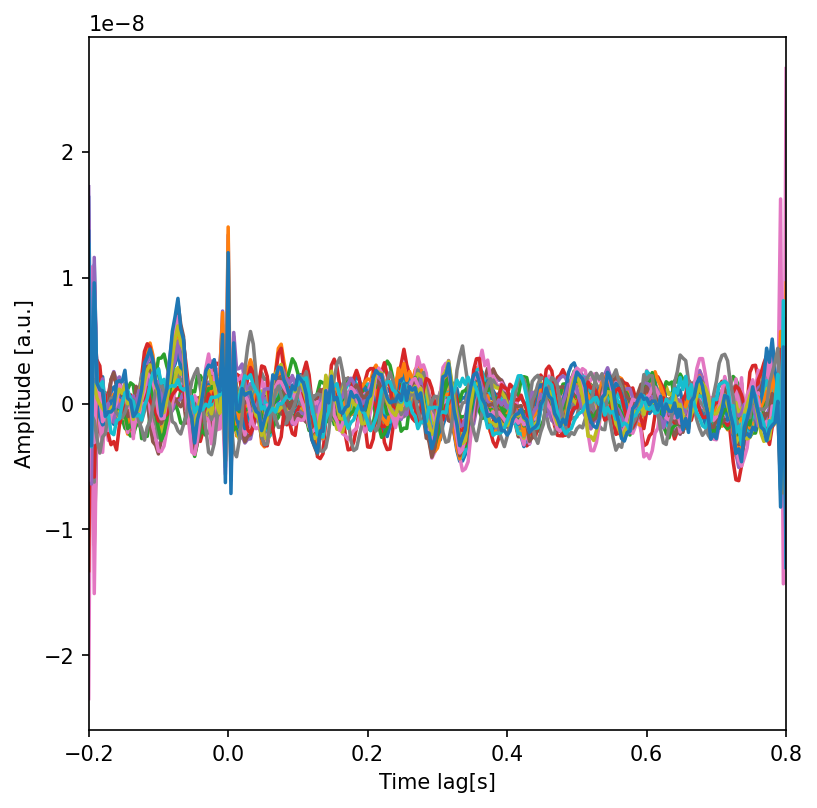

In [11]:
from mtrf.model import TRF
from mtrf.stats import crossval
import mtrf

print(len(split_audio))

for i in range(len(split_eeg)):
    split_audio[i] = split_audio[i].T

    split_eeg[i] = split_eeg[i].T

split_eeg = np.array(split_eeg)
split_audio = np.array(split_audio)

fwd_trf = TRF(direction=1, metric=mtrf.stats.neg_mse)
tmin = -0.2
tmax = 0.8
lam = 1
#print(crossval(fwd_trf, list(split_audio), list(split_eeg), 250, tmin, tmax, lam, k=5))
fwd_trf.train(list(split_audio), list(split_eeg), 250, tmin, tmax, lam)
fwd_trf.plot()

In [12]:
#hyperparameters
alphas = [10.**x for x in np.arange(5,30)]
alphas = list(np.sort(alphas))
ratios = [x/10 for x in np.arange(1,10)]

# alphas = [10.**15]
# ratios = [0]

print("Starting L2 Regularization:")
l2_res = cross_validation(X, Y, K=1, method = 'l2', alpha = alphas, ratio = ratios)
print(l2_res)

# print("\nStarting L1 Regularization:")
# l1_res = cross_validation(X, Y, K=1, method = 'l1', alpha = alphas, ratio = ratios)
# print(l1_res)

# print("\nStarting elasticnet Regularization:")
# elastic_res = cross_validation(X, Y, K=1, method = 'elastic', alpha = alphas, ratio = ratios)
# print(elastic_res)

print(np.log10(alphas))
#plt.plot(np.log10(alphas), list(l1_res.values()), color='b', label="L1")
plt.plot(np.log10(alphas), list(l2_res.values()), color='r', label="L2")
plt.xlabel('Regularization Value (Exponent)')
plt.ylabel('MSE')
plt.legend()
plt.title('L1 and L2 Regularization Cross Validation Scores')
plt.show()

# best_l1 = list(l1_res.keys())[0]
# for i in l1_res:
#     if l1_res[i] < l1_res[best_l1]:
#         best_l1 = i

# print(f"\nBest L1 regularization value: {best_l1} with MSE score of {l1_res[best_l1]}\n")


best_l2 = list(l2_res.keys())[0]
for i in l2_res:
    if l2_res[i] < l2_res[best_l2]:
        best_l2 = i

print(f"\nBest L2 regularization value: {best_l2} with MSE score of {l2_res[best_l2]}\n")


fig, axs = plt.subplots(2, 1)

axs[0].plot()

# best_elastic = list(elastic_res.keys())[0]
# for i in elastic_res:
#     if elastic_res[i] < elastic_res[best_elastic]:
#         best_elastic = i

# print(f"\nBest elasticnet regularization value: {best_elastic} with MSE score of {elastic_res[best_elastic]}\n")

Starting L2 Regularization:


KeyboardInterrupt: 

In [21]:
from matplotlib import pyplot as plt
scaler = StandardScaler()


# X_all = []
# Y_all = []
# for i in range(1,len(X)):
#     X_all.extend(X[f'song{i}'])
#     Y_all.extend(Y[f'song{i}'].T)

# X_train = []
# Y_train = []
# for i in range(1,len(X)//2):
#     X_train.extend(X[f'song{i}'])
#     Y_train.extend(Y[f'song{i}'].T)

# X_all = np.array(X_all)
# Y_all = np.array(Y_all)

# X_train = np.array(X_train)
# Y_train = np.array(Y_train)

raw_data = raw.get_data()

results = 0

scaler = StandardScaler()

X_scaled = {}
Y_scaled = {}
for i in X:
    X_scaled[i] = X[i]
    Y_scaled[i] = Y[i]

for i in X:
    if type(results) == int:
        results = train_l2(X[i], Y[i].T, 1e13, 250)
    else:
        results += train_l2(X[i], Y[i].T, 1e13, 250)

results = results/len(X)




fig, axs = plt.subplots(4, 8)
plt.suptitle("All Channels of TRF (Averaged Over Each Song)")
for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot(np.linspace(-0.25, 0.85, results.shape[0]), results[:,(i*8) + j])
            #axs[i, j].plot(np.linspace(-0.25, 0.85, model.coef_.shape[0]), model.coef_[:,(i*8) + j])

        except Exception as e:
            axs[i, j].plot(np.linspace(-0.25,0.85, results.shape[0]), results)
            print(f"{e}")


fig, axs = plt.subplots(4, 8)
plt.suptitle("All channels of reconstructed EEG data")

for i in range(4):
    for j in range(8):
        try:
            axs[i, j].plot((X_scaled['song2']@results)[:,(i*8) + j])
            #axs[i, j].plot(models[0].predict(X['song3'])[:,(i*8) + j])

            axs[i,j].plot(Y_scaled['song2'][(i*8) + j])
        except Exception as e:
            axs[i, j].plot((X_scaled['song2']@results))
            #axs[i, j].plot(models[0].predict(X['song2']))

            axs[i, j].plot(Y_scaled['song2'].T)

plt.show()



# plt.plot((X['song1']@results)[:,0]/0.1)
# plt.plot(Y['song1'][0])
# plt.show()
# print(Y['song1'].shape)
# print((X['song1']@results).shape)


index 31 is out of bounds for axis 1 with size 31


In [ ]:
from scipy.sparse import diags
import matplotlib.pyplot as plt

response = train_eeg
#lag_matrix = train_lag

n = (lag_matrix.T@lag_matrix).shape[0]
k = [-np.ones(n-1),2*np.ones(n),-np.ones(n-1)]
offset = [-1,0,1]
M = diags(k,offset).asarray()

M[0,0] -= 1
M[-1, -1] -= 1
M *= fs

results = np.linalg.inv(lag_matrix.T@lag_matrix +1e10*M)@(lag_matrix.T@response.T)*fs

print(results.shape)
print(audio.shape)

plt.plot(np.linspace(-250, 850, results.shape[0]),results)
plt.show()

In [ ]:

test_start = [0, 0, 0]
temp = np.array([mask(test_audio, len(test_audio), [test_start], 100, 50)]).T
test_lag= np.array([mask(test_audio, len(test_audio), [test_start], 100, 100)]).T*lag_mat(test_audio, fs)

print(mean_squared_error(test_eeg.T, test_lag@results))
plt.plot(np.linspace(0, test_eeg.shape[1], test_eeg.shape[1]), test_eeg.T, (test_lag@results))
plt.legend()
plt.show()
l1 = Lasso(alpha = 1e10)
elastic = ElasticNet(alpha = 1e10, l1_ratio=0.1)
l1.fit(lag_matrix, train_eeg.T)
elastic.fit(lag_matrix, train_eeg.T)
predicted = l1.predict(test_lag)
print(mean_squared_error(test_eeg.T, predicted))
predicted = elastic.predict(test_lag)
print(mean_squared_error(test_eeg.T, predicted))